In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# If you have more than 1 GPU, you might want to specify which GPU for training.
# In this case, I have 2 GPU and the second one is RTX 2080ti, so I pick the `second` one.
os.environ['CUDA_VISIBLE_DEVICES']='1' # The second
tf.config.set_soft_device_placement(True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Constants

In [2]:
d_name = '20211116_wmt19_en_zh'
folder_name = '20211119_translate_mle_en_zh'

encoder_wv_dim = 32
decoder_wv_dim = 32
encoder_que_pad = 65
decoder_que_pad = 207

In [3]:
if not os.path.isdir(folder_name):
    os.makedirs(folder_name)

# Load data

In [4]:
encoder_train = pickle.load(open(f'{d_name}/encoder_train.pkl', 'rb'))
decoder_train = pickle.load(open(f'{d_name}/decoder_train.pkl', 'rb'))
teacher_train = pickle.load(open(f'{d_name}/teacher_train.pkl', 'rb'))
encoder_vali  = pickle.load(open(f'{d_name}/encoder_vali.pkl', 'rb'))
decoder_vali  = pickle.load(open(f'{d_name}/decoder_vali.pkl', 'rb'))
teacher_vali  = pickle.load(open(f'{d_name}/teacher_vali.pkl', 'rb'))

decoder_idx2word   = pickle.load(open(f'{d_name}/en_idx2word.pkl','rb'))
decoder_word2idx   = pickle.load(open(f'{d_name}/en_word2idx.pkl','rb'))
encoder_idx2word   = pickle.load(open(f'{d_name}/zh_idx2word.pkl','rb'))
encoder_word2idx   = pickle.load(open(f'{d_name}/zh_word2idx.pkl','rb'))

decoder_emb32   = pickle.load(open(f'{d_name}/en_emb32.pkl', 'rb'))
encoder_emb32   = pickle.load(open(f'{d_name}/zh_emb32.pkl', 'rb'))

In [5]:
print(encoder_train.shape)
print(teacher_train.shape)

(221040, 65)
(221040, 207)


In [6]:
num_decoder_words = np.max([np.max(decoder_train), np.max(decoder_vali)])+1
num_encoder_words = np.max([np.max(encoder_train), np.max(encoder_vali)])+1

print(num_decoder_words)
print(num_encoder_words)

199
4716


In [7]:
def seq2word(seq_tensor, idx2word):
    return [''.join([idx2word[i] for i in seq]) for seq in seq_tensor]

In [8]:
seq2word(decoder_vali[:1], decoder_idx2word)

['<bos>1929 or 1989?<eos>                                                                                                                                                                                                ']

In [9]:
seq2word(encoder_vali[:1], encoder_idx2word)

['1929年还是1989年?                                                    ']

# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10, 64)


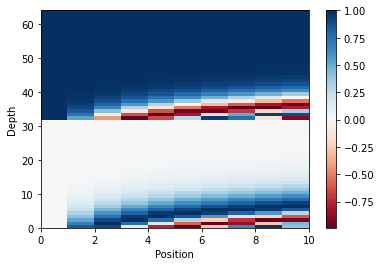

In [11]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Generator

[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [12]:
def Transformer(q_que_pad, k_que_pad, wv_dim, k_wv_dim, rate = 0.1, mask = ''):
    # Inputs
    mem  = Input((q_que_pad, wv_dim))
    encode = Input((k_que_pad, k_wv_dim))
    # Constants
    ff_dim = wv_dim*64
    # Multi-Head Attention
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(encode)
    v = Dense(wv_dim)(encode)
    # Choose a mask, default: BERT (no mask)
    mask_weights = np.ones((q_que_pad, k_que_pad))
    if mask == 'GPT':
        mask_weights = np.tri(q_que_pad, k_que_pad, 0)
    mem_new = MultiHeadAttention(
        num_heads = 4,
        key_dim = wv_dim, 
        value_dim = wv_dim
    )(
        q, k, v,
        attention_mask = mask_weights
    )
    mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        [mem, encode],
        [mem_new, out],
    )
    return model

def getE(wv_dim = 16):
    _input = Input((encoder_que_pad,))
    emb = Embedding(
        num_encoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(encoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(encoder_emb32),
    )
    mem = emb(_input)
    # position encoding
    pe = positional_encoding(encoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # forward sentence
    for i in range(1):
        gptLayer = Transformer(encoder_que_pad, encoder_que_pad, wv_dim, wv_dim)
        mem, output = gptLayer((mem, mem))
        output = Activation('relu')(output)
        mem = Activation('relu')(mem)
    # Output
    model = Model(
        _input, 
        output) 
    return model

def getD(wv_dim = 8, encoder_wv_dim = 16):
    en_output = Input((encoder_que_pad, encoder_wv_dim))
    de_input  = Input((decoder_que_pad,))
    emb = Embedding(
        num_decoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(decoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(decoder_emb32),
    )
    mem = emb(de_input)
    # position encoding
    pe = positional_encoding(decoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # Attention
    for j in range(1):
        # Self attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, decoder_que_pad, wv_dim, wv_dim, mask = 'GPT')
            mem, _ = gptLayer((mem, mem))
            mem = Activation('relu')(mem)
        # Cross attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, encoder_que_pad, wv_dim, encoder_wv_dim)
            mem, output = gptLayer((mem, en_output))
            output = Activation('relu')(output)
            mem = Activation('relu')(mem)
    # Concatenation and output
    output = Dense(num_decoder_words)(output)
    output = Activation('softmax')(output)
    model = Model(
        [en_output, de_input], 
        output,
    )
    return model

# Language Model
def getLM():
    # Inputs
    en_input = Input((encoder_que_pad,))
    de_input = Input((decoder_que_pad,))
    # Encoder (Chinese -> code)
    encoder = getE(encoder_wv_dim)
    encoder.summary()
    en_output = encoder(en_input)
    # Decoder (code -> English)
    decoder = getD(decoder_wv_dim, encoder_wv_dim)
    decoder.summary()
    de_output = decoder([en_output, de_input])
    # Establish the model
    model = Model(
        [en_input, de_input],
        de_output,
    )
    return model

In [13]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 65, 32)       150912      input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 65, 32)       0           embedding[0][0]                  
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 65, 32)       64          tf.__operators__.add[0][0]       
____________________________________________________________________________________________

In [ ]:
mleG.fit(
    [encoder_train, decoder_train], 
    teacher_train, 
    batch_size=128, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        [encoder_vali, decoder_vali], 
        teacher_vali
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/mleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/mleG.csv'),
    ]
)

Epoch 1/300
1727/1727 [==============================] - 79s 44ms/step - loss: 1.4451 - accuracy: 0.6208 - val_loss: 1.0122 - val_accuracy: 0.6995
Epoch 2/300
1727/1727 [==============================] - 76s 44ms/step - loss: 0.9817 - accuracy: 0.7081 - val_loss: 0.8646 - val_accuracy: 0.7418
Epoch 3/300
1727/1727 [==============================] - 75s 44ms/step - loss: 0.9040 - accuracy: 0.7301 - val_loss: 0.8128 - val_accuracy: 0.7562
Epoch 4/300
1727/1727 [==============================] - 76s 44ms/step - loss: 0.8669 - accuracy: 0.7408 - val_loss: 0.7828 - val_accuracy: 0.7651
Epoch 5/300
1727/1727 [==============================] - 76s 44ms/step - loss: 0.8419 - accuracy: 0.7483 - val_loss: 0.7597 - val_accuracy: 0.7713
Epoch 6/300
1727/1727 [==============================] - 76s 44ms/step - loss: 0.8232 - accuracy: 0.7538 - val_loss: 0.7391 - val_accuracy: 0.7776
Epoch 7/300
1727/1727 [==============================] - 76s 44ms/step - loss: 0.8083 - accuracy: 0.7583 - val_loss: 0

In [23]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 10s 13ms/step - loss: 0.5854 - accuracy: 0.8248
0.5854150652885437


No handles with labels found to put in legend.


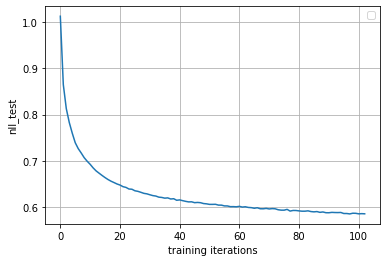

In [24]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/mleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-1]))
plt.plot(nll_mle, )
plt.grid(True)
plt.ylabel('nll_test')
plt.xlabel('training iterations')
plt.legend()
plt.show()

## Inference train D (False) 

In [16]:
def inference(
    model,
    enData = None,
):
    # Initialize
    resp_pred_list = None
    in_batch_list = None
    the_first = True
    
    in_batch = np.zeros((len(enData), decoder_que_pad), dtype = int)
    in_batch[:,0] = decoder_word2idx['<bos>']
    en_batch = enData
    resp_pred = np.zeros(in_batch.shape, dtype = int)
    # Generate the sequence recurrsively.
    for i in range(decoder_que_pad):
        # Run
        resp_pred_wv = model([en_batch, in_batch])
        the_last = resp_pred_wv[:,i]
        # Stochastic
        the_last_one = tf.reshape(
            tf.random.categorical(tf.math.log(the_last), 1), 
            [len(enData),]
        )
        # TODO: greedy
        the_last_two = tf.math.argmax(the_last, axis = 1)
        try:
            resp_pred[:,i] = the_last_one
            in_batch[:,i+1] = the_last_one
        except:
            resp_pred[:,i] = the_last_one
    # Remove the words after <eos>
    for i in range(len(resp_pred)):
        try:
            index = list(resp_pred[i]).index(en_word2idx['<eos>'])
        except:
            continue
        resp_pred[i,index+1:] = 0
        in_batch[i,index+1:] = 0
        
    return resp_pred, in_batch

In [39]:
resp_pred_list, _ = inference(mleG, [encoder_vali[123]])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word([decoder_vali[123]], decoder_idx2word))

# Predicted sequence
['For India, taken unifying it followed the European distry.<eos>                                                                                                                                                    ']
# Real sequence
['<bos>The coming year will be particularly important for Europe.<eos>                                                                                                                                                   ']


# Step 2: Slow MLE

In [40]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate = 1e-5),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 65, 32)       150912      input_14[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_8 (TFOpLam (None, 65, 32)       0           embedding_2[0][0]                
__________________________________________________________________________________________________
layer_normalization_8 (LayerNor (None, 65, 32)       64          tf.__operators__.add_8[0][0]     
____________________________________________________________________________________________

In [41]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 11s 13ms/step - loss: 0.5854 - accuracy: 0.8248
0.5854150652885437


In [ ]:
mleG.fit(
    [encoder_train, decoder_train], 
    teacher_train, 
    batch_size=128, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        [encoder_vali, decoder_vali], 
        teacher_vali
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/slowmleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/slowmleG.csv'),
    ]
)

Epoch 1/300
1727/1727 [==============================] - 79s 44ms/step - loss: 0.6407 - accuracy: 0.8096 - val_loss: 0.5776 - val_accuracy: 0.8272
Epoch 2/300
1727/1727 [==============================] - 75s 43ms/step - loss: 0.6385 - accuracy: 0.8102 - val_loss: 0.5766 - val_accuracy: 0.8274
Epoch 3/300
1727/1727 [==============================] - 75s 44ms/step - loss: 0.6378 - accuracy: 0.8104 - val_loss: 0.5761 - val_accuracy: 0.8276
Epoch 4/300
1727/1727 [==============================] - 76s 44ms/step - loss: 0.6373 - accuracy: 0.8105 - val_loss: 0.5757 - val_accuracy: 0.8277
Epoch 5/300
1727/1727 [==============================] - 75s 43ms/step - loss: 0.6370 - accuracy: 0.8106 - val_loss: 0.5755 - val_accuracy: 0.8277
Epoch 6/300
1727/1727 [==============================] - 75s 44ms/step - loss: 0.6368 - accuracy: 0.8107 - val_loss: 0.5754 - val_accuracy: 0.8278
Epoch 7/300
1727/1727 [==============================] - 71s 41ms/step - loss: 0.6365 - accuracy: 0.8108 - val_loss: 0

No handles with labels found to put in legend.


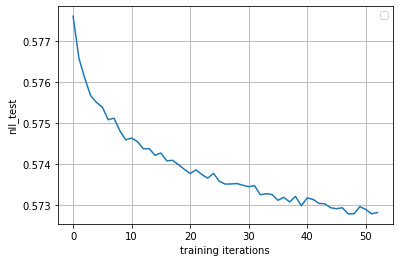

In [45]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/slowmleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-1]))
plt.plot(nll_mle, )
plt.grid(True)
plt.ylabel('nll_test')
plt.xlabel('training iterations')
plt.legend()
plt.show()

In [14]:
mleG.load_weights(f'./{folder_name}/slowmleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 11s 13ms/step - loss: 0.5728 - accuracy: 0.8285
0.5727848410606384


In [18]:
resp_pred_list, _ = inference(mleG, [encoder_vali[123]])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word([decoder_vali[123]], decoder_idx2word))

# Predicted sequence
['The implies in important join likely impresses spented.<eos>                                                                                                                                                       ']
# Real sequence
['<bos>The coming year will be particularly important for Europe.<eos>                                                                                                                                                   ']
